In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import tree

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn


In [2]:
data = pd.read_csv('./Dataset_dumarey/dataset_rounded.csv')

In [3]:
data.head()


,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,01/01/2021 20:31,01/01/2021 20:38,"443,664","443,947",564,549.0,trip,NaN
1,-8.99632E+ 18,01/01/202120:39,02/01/202115:13,"443,947","443,947",549,100.0,charge,240
2,-8.99632E+18,02/01/202115:13,02/01/202115:21,"443,947","444,250",100,100.0,trip,NaN
3,-8.99632E+18,02/01/202115:21,02/01/202117:46,"444,250","445,713",100,945.0,trip,NaN
4,-8.99632E+18,02/01/202117:46,02/01/202117:53,"445,713","446,145",945,945.0,trip,NaN


In [4]:
print(f"Element of the dataset: {len(data)}")
print(f"Columns of the dataset: {data.columns.to_list()}")
data.info()

Element of the dataset: 32
Columns of the dataset: ['vm', 'timestamp', 'end_time', 'odo', 'end_odo', 'soc', 'end_soc', 'event', 'charge_mode']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vm           32 non-null     object 
 1   timestamp    32 non-null     object 
 2   end_time     32 non-null     object 
 3   odo          32 non-null     object 
 4   end_odo      32 non-null     object 
 5   soc          31 non-null     object 
 6   end_soc      31 non-null     float64
 7   event        32 non-null     object 
 8   charge_mode  8 non-null      object 
dtypes: float64(1), object(8)
memory usage: 2.4+ KB


In [5]:
data.describe()

,end_soc
count,31.000000
mean,503.967742
std,283.321429
min,16.000000
25%,437.000000
50%,584.000000
75%,654.000000
max,945.000000


In [6]:
def remove_comma(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(",", ".")         
    ts = ts.replace(". ", ".")        
    return ts 

In [7]:
data['odo'] = data['odo'].apply(remove_comma)
data['end_odo'] = data['end_odo'].apply(remove_comma)
data['soc'] = data['soc'].apply(remove_comma)
data['end_soc'] = data['end_soc'].apply(remove_comma)

In [8]:
cols_to_float = ['odo', 'end_odo', 'soc', 'end_soc']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vm           32 non-null     object 
 1   timestamp    32 non-null     object 
 2   end_time     32 non-null     object 
 3   odo          32 non-null     float64
 4   end_odo      32 non-null     float64
 5   soc          29 non-null     float64
 6   end_soc      31 non-null     float64
 7   event        32 non-null     object 
 8   charge_mode  8 non-null      object 
dtypes: float64(4), object(5)
memory usage: 2.4+ KB


In [10]:
import re

def fix_timestamp_format(ts):
    if pd.isna(ts):
        return ts  
    ts = str(ts).strip()
    
    if re.match(r"\d{2}/\d{2}/\d{4} \d{2}:\d{2}", ts):
        return ts
    elif re.match(r"\d{2}/\d{2}/\d{4}\d{2}:\d{2}", ts):
        return ts[:10] + ' ' + ts[10:]
    else:
        return ts 


data['timestamp'] = data['timestamp'].apply(fix_timestamp_format)
data['end_time'] = data['end_time'].apply(fix_timestamp_format) 

In [11]:
data.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,01/01/2021 20:31,01/01/2021 20:38,443.664,443.947,564.0,549.0,trip,NaN
1,-8.99632E+ 18,01/01/2021 20:39,02/01/2021 15:13,443.947,443.947,549.0,100.0,charge,240
2,-8.99632E+18,02/01/2021 15:13,02/01/2021 15:21,443.947,444.250,100.0,100.0,trip,NaN
3,-8.99632E+18,02/01/2021 15:21,02/01/2021 17:46,444.250,445.713,100.0,945.0,trip,NaN
4,-8.99632E+18,02/01/2021 17:46,02/01/2021 17:53,445.713,446.145,945.0,945.0,trip,NaN


In [12]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce')

In [13]:
data.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,2021-01-01 20:31:00,2021-01-01 20:38:00,443.664,443.947,564.0,549.0,trip,NaN
1,-8.99632E+ 18,2021-01-01 20:39:00,2021-02-01 15:13:00,443.947,443.947,549.0,100.0,charge,240
2,-8.99632E+18,2021-02-01 15:13:00,2021-02-01 15:21:00,443.947,444.250,100.0,100.0,trip,NaN
3,-8.99632E+18,2021-02-01 15:21:00,2021-02-01 17:46:00,444.250,445.713,100.0,945.0,trip,NaN
4,-8.99632E+18,2021-02-01 17:46:00,2021-02-01 17:53:00,445.713,446.145,945.0,945.0,trip,NaN


In [14]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

| Features | NaN-counter |
vm              0
timestamp       0
end_time        0
odo             0
end_odo         0
soc             3
end_soc         1
event           0
charge_mode    24
dtype: int64
|----------|-------------|


In [15]:
duplicates = data.duplicated()
print(f"Duplicates: {duplicates.sum()}")
data = data[~duplicates]

Duplicates: 0


In [16]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 32


In [17]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data[col] = data[col].astype('category')
data['charge_mode'] = data['charge_mode'].cat.add_categories('0').fillna('0')

In [18]:
# add a column duration
data['duration'] = (data['end_time'] - data['timestamp']).dt.total_seconds()/60

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vm           32 non-null     object        
 1   timestamp    32 non-null     datetime64[ns]
 2   end_time     32 non-null     datetime64[ns]
 3   odo          32 non-null     float64       
 4   end_odo      32 non-null     float64       
 5   soc          29 non-null     float64       
 6   end_soc      31 non-null     float64       
 7   event        32 non-null     category      
 8   charge_mode  32 non-null     category      
 9   duration     32 non-null     float64       
dtypes: category(2), datetime64[ns](2), float64(5), object(1)
memory usage: 2.4+ KB


In [20]:
#per la colonna vm, cambia tutti i valori che iniziano con -8.9 in 1 e in tipo float64
data['vm'] = data['vm'].apply(lambda x: 1.0 if str(x).startswith('-8.9') else x)
data['vm'] = data['vm'].astype('Float64')

# OneHotEncoder

In [21]:
ohe = OneHotEncoder(handle_unknown='ignore')
# Fit the one-hot encoder on training data
ohe.fit(data[cols_to_convert])
# Create a new DataFrame with only the one-hot encoded columns
temp_data = pd.DataFrame(data=ohe.transform(data[cols_to_convert]).toarray(),
                             columns=ohe.get_feature_names_out())
# Create a copy of the DataFrame
data_encoded = data.copy()

# Remove the old categorical columns from the original data
data_encoded.drop(columns=cols_to_convert, axis=1, inplace=True)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), temp_data], axis=1)


In [22]:
data_encoded.head()
#remove the column charge_mode_nan
data_encoded.drop(columns=['charge_mode_0'], axis=1, inplace=True)
data_encoded.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_charge,event_trip,charge_mode_240,charge_mode_DCCharging
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,443.664,443.947,564.0,549.0,7.0,0.0,1.0,0.0,0.0
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,443.947,443.947,549.0,100.0,44314.0,1.0,0.0,1.0,0.0
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,443.947,444.250,100.0,100.0,8.0,0.0,1.0,0.0,0.0
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,444.250,445.713,100.0,945.0,145.0,0.0,1.0,0.0,0.0
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,445.713,446.145,945.0,945.0,7.0,0.0,1.0,0.0,0.0


In [23]:
#selecting numerical columns
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Selecting only numerical columns for correlation
numerical_data = data_encoded[numerical_cols]


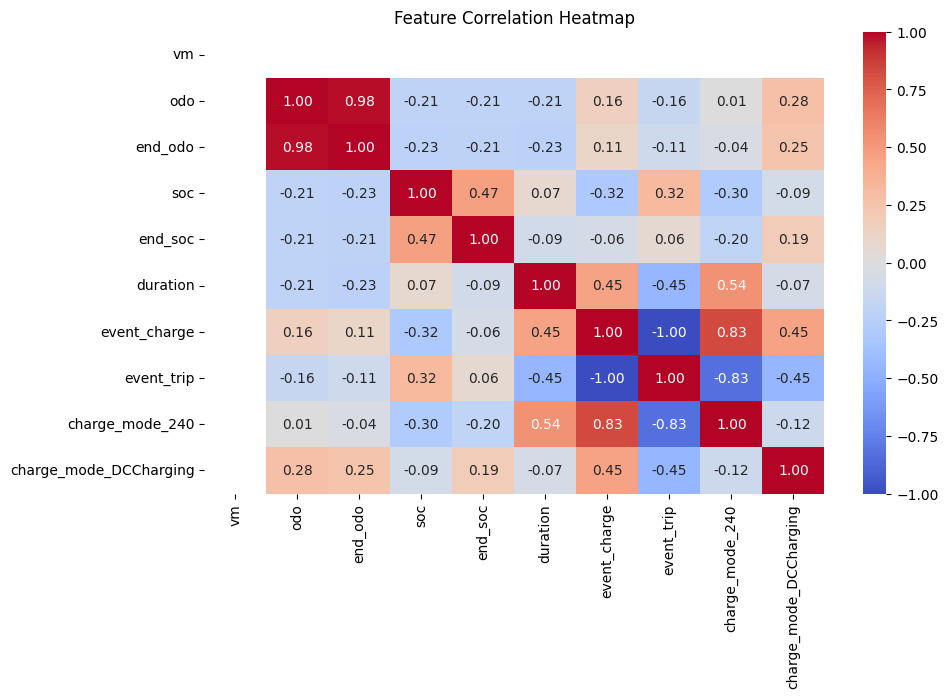

In [24]:

plt.figure(figsize=(10, 6))
g = sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
data_encoded.to_csv('./Dataset_dumarey/dataset_rounded_OHE.csv', index=False)

# 2D Embedding

In [26]:
data_embedded = data.copy()

In [27]:
data_embedded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vm           32 non-null     Float64       
 1   timestamp    32 non-null     datetime64[ns]
 2   end_time     32 non-null     datetime64[ns]
 3   odo          32 non-null     float64       
 4   end_odo      32 non-null     float64       
 5   soc          29 non-null     float64       
 6   end_soc      31 non-null     float64       
 7   event        32 non-null     category      
 8   charge_mode  32 non-null     category      
 9   duration     32 non-null     float64       
dtypes: Float64(1), category(2), datetime64[ns](2), float64(5)
memory usage: 2.5 KB


In [28]:
data_embedded.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,443.664,443.947,564.0,549.0,trip,0,7.0
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,443.947,443.947,549.0,100.0,charge,240,44314.0
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,443.947,444.250,100.0,100.0,trip,0,8.0
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,444.250,445.713,100.0,945.0,trip,0,145.0
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,445.713,446.145,945.0,945.0,trip,0,7.0


In [29]:
# === EMBEDDING PREPARATION ===
import torch
label_encoders = {}
cat_indices = {}
for col in cols_to_convert:
    le = LabelEncoder()
    cat_indices[col + "_idx"] = le.fit_transform(data_embedded[col].astype(str))
    label_encoders[col] = le

data_cat_idx = pd.DataFrame(cat_indices)
X_cat = torch.tensor(data_cat_idx.values, dtype=torch.long)

num_classes_per_cat = [len(label_encoders[col].classes_) for col in cols_to_convert]
embedding_dims = [2 for _ in num_classes_per_cat]  # oppure scegli dinamicamente

embedding_layers = nn.ModuleList([
    nn.Embedding(num_embeddings=n, embedding_dim=d)
    for n, d in zip(num_classes_per_cat, embedding_dims)
])

# 4. Applica gli embedding
embedded_parts = [embedding_layers[i](X_cat[:, i]) for i in range(X_cat.shape[1])]
embedded_features = torch.cat(embedded_parts, dim=1)  # [num_samples, total_emb_dim]

# Converti gli embedding in DataFrame
embedded_feature_names = []
for col, dim in zip(cols_to_convert, embedding_dims):
    embedded_feature_names.extend([f"{col}_emb_{i}" for i in range(dim)])

df_embedded = pd.DataFrame(embedded_features.detach().numpy(), columns=embedded_feature_names)


# === UNISCI CON LE FEATURE CONTINUE ===
# (escludi le colonne categoriche originali)
data_noncat = data_embedded.drop(columns=cols_to_convert).reset_index(drop=True)

# 7. Combina finali
data_embedded = pd.concat([data_noncat, df_embedded], axis=1)

In [30]:
data_embedded.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_emb_0,event_emb_1,charge_mode_emb_0,charge_mode_emb_1
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,443.664,443.947,564.0,549.0,7.0,-0.332122,-0.762352,-1.555530,0.182056
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,443.947,443.947,549.0,100.0,44314.0,-1.410632,0.490177,0.372326,-0.364595
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,443.947,444.250,100.0,100.0,8.0,-0.332122,-0.762352,-1.555530,0.182056
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,444.250,445.713,100.0,945.0,145.0,-0.332122,-0.762352,-1.555530,0.182056
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,445.713,446.145,945.0,945.0,7.0,-0.332122,-0.762352,-1.555530,0.182056


In [31]:
cols_to_convert = ['event_emb_0','event_emb_1', 'charge_mode_emb_0', 'charge_mode_emb_1']
data_embedded[cols_to_convert] = data_embedded[cols_to_convert].astype('float64')
data_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   vm                 32 non-null     Float64       
 1   timestamp          32 non-null     datetime64[ns]
 2   end_time           32 non-null     datetime64[ns]
 3   odo                32 non-null     float64       
 4   end_odo            32 non-null     float64       
 5   soc                29 non-null     float64       
 6   end_soc            31 non-null     float64       
 7   duration           32 non-null     float64       
 8   event_emb_0        32 non-null     float64       
 9   event_emb_1        32 non-null     float64       
 10  charge_mode_emb_0  32 non-null     float64       
 11  charge_mode_emb_1  32 non-null     float64       
dtypes: Float64(1), datetime64[ns](2), float64(9)
memory usage: 3.2 KB


In [32]:
#select the least recent date in timestamp
min_date = data_embedded['timestamp'].min()
#compute the difference in hour from the minimum date
data_embedded['timestamp'] = (data_embedded['timestamp'] - min_date).dt.total_seconds() / 3600
data_embedded['end_time'] = (data_embedded['end_time'] - min_date).dt.total_seconds() / 3600

In [33]:
#selecting numerical columns
numerical_cols = data_embedded.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Selecting only numerical columns for correlation
numerical_data = data_embedded[numerical_cols]


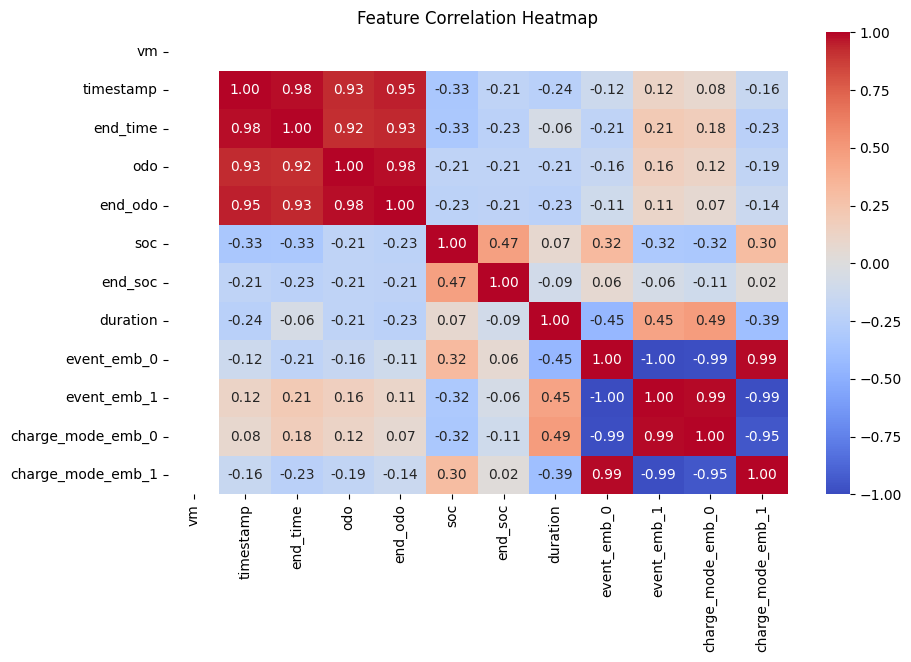

In [34]:

plt.figure(figsize=(10, 6))
g = sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [35]:
data_embedded.to_csv('./Dataset_dumarey/dataset_rounded_2DE.csv', index=False)

In [36]:
# Ripristina i valori originali da data_embedded
data_embedded['event'] = label_encoders['event'].inverse_transform(data_cat_idx['event_idx'])
data_embedded['charge_mode'] = label_encoders['charge_mode'].inverse_transform(data_cat_idx['charge_mode_idx'])

# Rimuovi le colonne inutili (embedding e indici)
data_from_2DE_to_original = data_embedded.drop(columns=[
    'event_emb_0', 'event_emb_1',
    'charge_mode_emb_0', 'charge_mode_emb_1'
])

In [37]:
data_from_2DE_to_original.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event,charge_mode
0,1.0,0.000000,0.116667,443.664,443.947,564.0,549.0,7.0,trip,0
1,1.0,0.133333,738.700000,443.947,443.947,549.0,100.0,44314.0,charge,240
2,1.0,738.700000,738.833333,443.947,444.250,100.0,100.0,8.0,trip,0
3,1.0,738.833333,741.250000,444.250,445.713,100.0,945.0,145.0,trip,0
4,1.0,741.250000,741.366667,445.713,446.145,945.0,945.0,7.0,trip,0


In [38]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data_from_2DE_to_original[col] = data_from_2DE_to_original[col].astype('category')
data_from_2DE_to_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vm           32 non-null     Float64 
 1   timestamp    32 non-null     float64 
 2   end_time     32 non-null     float64 
 3   odo          32 non-null     float64 
 4   end_odo      32 non-null     float64 
 5   soc          29 non-null     float64 
 6   end_soc      31 non-null     float64 
 7   duration     32 non-null     float64 
 8   event        32 non-null     category
 9   charge_mode  32 non-null     category
dtypes: Float64(1), category(2), float64(7)
memory usage: 2.5 KB


- Trasformare gli object in float64 (Done)
- Capire come gestire le date (Done)
- Data fine evento si può convertire in durata evento? (ho inserito la data duration)
- Verificare se ci siano valori null (Done)
- Verificare se ci sono duplicati (Done)
- Fare feature correlation heatmap (Done)
- Onehot encoding (Done)
- Trasformare la colonna vm dato che si riferisce a singoli veicoli(ID) tipo in vec1 vec2 ecc
- Come gestisco i missing values?  
- come convertire gli embeddings dopo la generazione? (classificatore, nearest neighbor, from sklearn.metrics.pairwise import euclidean_distances)
